## CAMELs sims

Just check we can load and plot the 2D CAMELs fields from IllustrisTNG

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from kymatio.numpy import Scattering2D
from sn_camels.models.models_factory import baseModelFactory, topModelFactory
from sn_camels.models.sn_hybrid_models import sn_HybridModel
import torch

In [2]:
from sn_camels.scattering import kymat_code

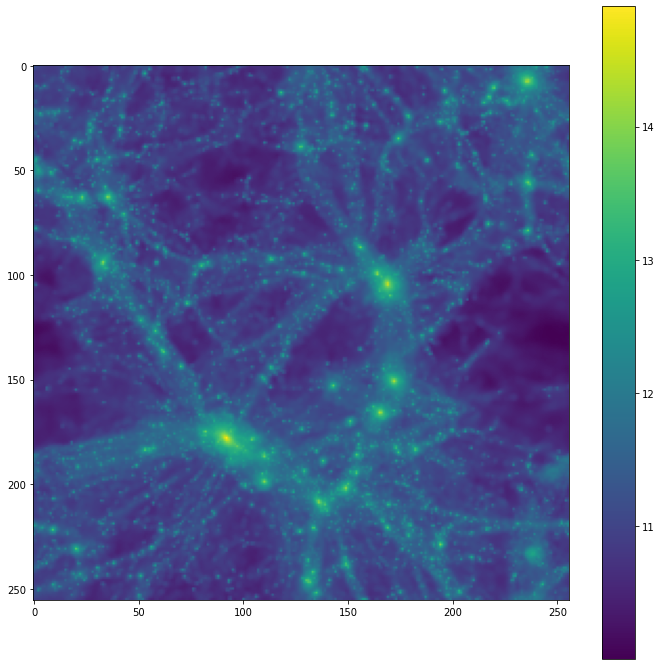

In [3]:
camels_path="/home/chrisp/Data/CAMELs"

data_string=camels_path+"/Maps_Mcdm_IllustrisTNG_LH_z=0.00.npy"
param_string=camels_path+"/params_IllustrisTNG.txt"

## Import maps and parameters
maps = np.load(data_string)
params=np.loadtxt(param_string)

maps=maps[:10]

##Pick a field, any field
field_index=np.random.randint(len(maps))

plt.figure(figsize=(12,12))
plt.imshow(np.log10(maps[field_index]))
plt.colorbar()

In [4]:
## Make one of our sn_camels models
scatteringBase = baseModelFactory( #creat scattering base model
    architecture='scattering',
    J=2,
    N=256,
    M=256,
    channels=1,
    max_order=2,
    initialization="Random",
    seed=123,
    learnable=False,
    lr_orientation=0.1,
    lr_scattering=0.1,
    skip=False,
    split_filters=False,
    subsample=1,
    filter_video=False,
    device="cpu",
    use_cuda=False,
    plot=False
)


/home/chrisp/.local/lib/python3.8/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/home/chrisp/.local/lib/python3.8/site-packages/sn_camels-0.0.1-py3.8.egg/sn_camels/scattering/create_filters.py:283: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2981.)


In [ ]:
def do_convolutions_psi(x, backend, J, phi, psi, max_order,
        split_filters, subsample):
    """ Function to take an input image and perform a series of scattering
    convolutions."""
    subsample_fourier = backend.subsample_fourier
    modulus = backend.modulus
    fft = backend.fft
    cdgmm = backend.cdgmm
    concatenate = backend.concatenate

    # Define lists for output.
    out_S_0, out_S_1, out_S_2 = [], [], []
    
    ## Map to complex
    complex_maps = x.new_zeros(x.shape + (2,))
    complex_maps[..., 0] = x

    U_0_c = fft(complex_maps, 'C2C')

    # First low pass filter
    U_1_c = cdgmm(U_0_c, phi[0])
    U_1_c = subsample_fourier(U_1_c, k=subsample)


    S_0 = fft(U_1_c, 'C2R', inverse=True)

    out_S_0.append({'coef': S_0,
                    'j': (),
                    'theta': ()})

    if split_filters:
        for n1 in range(int(len(psi)/2)):
            j1 = psi[n1]['j'] ## don't care about this any more
            theta1 = psi[n1]['theta']

            ## Wavelet convolution
            U_1_c = cdgmm(U_0_c, psi[n1][0])

            U_1_c = fft(U_1_c, 'C2C', inverse=True)
            U_1_c = modulus(U_1_c)
            U_1_c = fft(U_1_c, 'C2C')

            ## Second low pass filter
            S_1_c = cdgmm(U_1_c, phi[0])
            S_1_c = subsample_fourier(S_1_c, k=subsample)

            S_1_r = fft(S_1_c, 'C2R', inverse=True)

            out_S_1.append({'coef': S_1_r,
                            'j': (j1,),
                            'theta': (theta1,)})

            if max_order < 2:
                continue
            for n2 in range(int(len(psi)/2),len(psi)):
                j2 = psi[n2]['j']
                theta2 = psi[n2]['theta']
                

                U_2_c = cdgmm(U_1_c, psi[n2][0])
                U_2_c = fft(U_2_c, 'C2C', inverse=True)
                U_2_c = modulus(U_2_c)
                U_2_c = fft(U_2_c, 'C2C')

                ## Low pass filter
                S_2_c = cdgmm(U_2_c, phi[0])
                
                S_2_c = subsample_fourier(S_2_c, k=subsample)

                S_2_r = fft(S_2_c, 'C2R', inverse=True)
                

                out_S_2.append({'coef': S_2_r,
                                'j': (j1, j2),
                                'theta': (theta1, theta2)})
    else:
        for n1 in range(len(psi)):
            j1 = psi[n1]['j'] ## don't care about this any more
            theta1 = psi[n1]['theta']

            ## Wavelet convolution
            U_1_c = cdgmm(U_0_c, psi[n1][0])

            U_1_c = fft(U_1_c, 'C2C', inverse=True)
            U_1_c = modulus(U_1_c)
            U_1_c = fft(U_1_c, 'C2C')

            ## Second low pass filter
            S_1_c = cdgmm(U_1_c, phi[0])
            S_1_c = subsample_fourier(S_1_c, k=subsample)

            S_1_r = fft(S_1_c, 'C2R', inverse=True)

            out_S_1.append({'coef': S_1_r,
                            'j': (j1,),
                            'theta': (theta1,)})

            if max_order < 2:
                continue
            for n2 in range(len(psi)):
                j2 = psi[n2]['j']
                theta2 = psi[n2]['theta']
                

                U_2_c = cdgmm(U_1_c, psi[n2][0])
                U_2_c = fft(U_2_c, 'C2C', inverse=True)
                U_2_c = modulus(U_2_c)
                U_2_c = fft(U_2_c, 'C2C')

                ## Low pass filter
                S_2_c = cdgmm(U_2_c, phi[0])
                S_2_c = subsample_fourier(S_2_c, k=subsample)
                S_2_r = fft(S_2_c, 'C2R', inverse=True)
                

                out_S_2.append({'coef': S_2_r,
                                'j': (j1, j2),
                                'theta': (theta1, theta2)})

    out_S = []
    out_S.extend(out_S_0)
    out_S.extend(out_S_1)
    out_S.extend(out_S_2)

    out_S = concatenate([x['coef'] for x in out_S])

    return out_S


In [ ]:
def do_convolutions_wave(x, backend, J, phi, wavelets, max_order,
        split_filters, subsample):
    """ Function to take an input image and perform a series of scattering
    convolutions."""
    subsample_fourier = backend.subsample_fourier
    modulus = backend.modulus
    fft = backend.fft
    cdgmm = backend.cdgmm
    concatenate = backend.concatenate
    
    ## unsqueeze
    print("unsqueeze")
    wavelets = wavelets.real.contiguous().unsqueeze(3)

    # Define lists for output.
    out_S_0, out_S_1, out_S_2 = [], [], []
    
    ## Map to complex
    complex_maps = x.new_zeros(x.shape + (2,))
    complex_maps[..., 0] = x

    U_0_c = fft(complex_maps, 'C2C')

    # First low pass filter
    U_1_c = cdgmm(U_0_c, phi[0])
    U_1_c = subsample_fourier(U_1_c, k=subsample)


    S_0 = fft(U_1_c, 'C2R', inverse=True)

    out_S_0.append({'coef': S_0})

    if split_filters:
        for n1 in range(int(len(wavelets)/2)):

            ## Wavelet convolution
            
            U_1_c = cdgmm(U_0_c, wavelets[n1])

            U_1_c = fft(U_1_c, 'C2C', inverse=True)
            U_1_c = modulus(U_1_c)
            U_1_c = fft(U_1_c, 'C2C')

            ## Second low pass filter
            S_1_c = cdgmm(U_1_c, phi[0])
            S_1_c = subsample_fourier(S_1_c, k=subsample)

            S_1_r = fft(S_1_c, 'C2R', inverse=True)

            out_S_1.append({'coef': S_1_r})

            if max_order < 2:
                continue
            for n2 in range(int(len(psi)/2),len(psi)):
                

                U_2_c = cdgmm(U_1_c, wavelets[n2])
                U_2_c = fft(U_2_c, 'C2C', inverse=True)
                U_2_c = modulus(U_2_c)
                U_2_c = fft(U_2_c, 'C2C')

                ## Low pass filter
                S_2_c = cdgmm(U_2_c, phi[0])
                
                S_2_c = subsample_fourier(S_2_c, k=subsample)

                S_2_r = fft(S_2_c, 'C2R', inverse=True)
                

                out_S_2.append({'coef': S_2_r})
    else:
        for n1 in range(len(wavelets)):
            ## Wavelet convolution
            U_1_c = cdgmm(U_0_c, wavelets[n1])

            U_1_c = fft(U_1_c, 'C2C', inverse=True)
            U_1_c = modulus(U_1_c)
            U_1_c = fft(U_1_c, 'C2C')

            ## Second low pass filter
            S_1_c = cdgmm(U_1_c, phi[0])
            S_1_c = subsample_fourier(S_1_c, k=subsample)

            S_1_r = fft(S_1_c, 'C2R', inverse=True)

            out_S_1.append({'coef': S_1_r})

            if max_order < 2:
                continue
            for n2 in range(len(wavelets)):
                
                U_2_c = cdgmm(U_1_c, wavelets[n2])
                U_2_c = fft(U_2_c, 'C2C', inverse=True)
                U_2_c = modulus(U_2_c)
                U_2_c = fft(U_2_c, 'C2C')

                ## Low pass filter
                S_2_c = cdgmm(U_2_c, phi[0])
                S_2_c = subsample_fourier(S_2_c, k=subsample)
                S_2_r = fft(S_2_c, 'C2R', inverse=True)
                

                out_S_2.append({'coef': S_2_r})

    out_S = []
    out_S.extend(out_S_0)
    out_S.extend(out_S_1)
    out_S.extend(out_S_2)

    out_S = concatenate([x['coef'] for x in out_S])

    return out_S


In [ ]:
out=do_convolutions_wave(torch.tensor(maps), scatteringBase.backend, scatteringBase.J, scatteringBase.scattering.phi, scatteringBase.wavelets, scatteringBase.max_order,
        scatteringBase.split_filters, scatteringBase.subsample)

In [ ]:
out=do_convolutions_psi(torch.tensor(maps), scatteringBase.backend, scatteringBase.J, scatteringBase.scattering.phi, scatteringBase.psi, scatteringBase.max_order,
        scatteringBase.split_filters, scatteringBase.subsample)

In [ ]:
print(scatteringBase.wavelets[0].shape)

In [ ]:
print(scatteringBase.scattering.psi[0][0].shape)

In [ ]:
scatteringBase.wavelets

In [ ]:
scatteringBase.psi[0][0]

In [ ]:
plt.imshow(scatteringBase.psi[0][0])

In [ ]:
scatteringBase.wavelets[0].real.shape

In [ ]:
scatteringBase.scattering.phi[0].shape

In [ ]:
scatteringBase.scattering.phi[0]

In [ ]:
plt.imshow(np.fft.fftshift(torch.reshape(scatteringBase.scattering.phi[0], (256,256))))

In [ ]:
plt.imshow(np.fft.fftshift(np.fft.ifft2(torch.reshape(scatteringBase.scattering.phi[0], (256,256))).real))

In [ ]:
x=torch.tensor(maps[field_index])
complex_maps = x.new_zeros(x.shape + (2,))
complex_maps[..., 0] = x

U_0_c = scatteringBase.scattering.backend.fft(complex_maps, 'C2C')

# First low pass filter
U_1_c = scatteringBase.scattering.backend.cdgmm(U_0_c, scatteringBase.scattering.phi[0])
S_0 = scatteringBase.scattering.backend.fft(U_1_c, 'C2R', inverse=True)

In [ ]:
plt.figure(figsize=(12,12))
plt.imshow(np.log10(maps[field_index]))
plt.colorbar()
plt.figure(figsize=(12,12))
plt.imshow(np.log10(S_0))
plt.colorbar()

In [ ]:
from sn_camels.scattering import kymat_code
from sn_camels.scattering import create_filters

In [ ]:
kymat_code.periodize_filter_fft(S_0,0)

In [ ]:
S_0.shape

## Plot some convolutions

In [ ]:
filter_1=2
filter_2=5
order2_index=17+filter_1*16+filter_2

cdm_map_num=7 # between 0 and 10

In [ ]:
plt.figure(figsize=(32,22))
plt.subplot(1, 3, 1)
plt.title("Original field")
plt.imshow(np.log10(maps[cdm_map_num]))
plt.subplot(1, 3, 2)
plt.title("Wavelet filter")
plt.imshow(np.fft.fftshift(np.fft.ifft2(scatteringBase.scattering.psi[filter_1][0].squeeze().cpu().detach().numpy())).real)
plt.subplot(1, 3, 3)
plt.title("First order convolved field")
plt.imshow(np.log10(out[cdm_map_num][filter_1+1]))
plt.figure(figsize=(32,22))
plt.subplot(1, 3, 1)
plt.title("Original field")
plt.imshow(np.log10(maps[cdm_map_num]))
plt.subplot(1, 3, 2)
plt.title("Wavelet filter")
plt.imshow(np.fft.fftshift(np.fft.ifft2(scatteringBase.scattering.psi[filter_2][0].squeeze().cpu().detach().numpy())).real)
plt.subplot(1, 3, 3)
plt.title("First order convolved field")
plt.imshow(np.log10(out[cdm_map_num][filter_2+1]))

In [ ]:
plt.figure(figsize=(32,22))
plt.subplot(1, 3, 1)
plt.title("First order 1 field")
plt.imshow(np.log10(out[cdm_map_num][filter_1+1]))
plt.subplot(1, 3, 2)
plt.title("First order 2 field")
plt.imshow(np.log10(out[cdm_map_num][filter_2+1]))
plt.subplot(1, 3, 3)
plt.title("Second order field")
plt.imshow(np.log10(out[cdm_map_num][order2_index]))

In [ ]:
scatteringBase.scattering.out_type